<a href="https://colab.research.google.com/github/TheodorosChristou/COM616_AE2_TheodorosChristou/blob/main/EfficientNet_Architecture_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_150 (Conv2D)         (None, 16, 16, 32)        864       
                                                                 
 batch_normalization_200 (B  (None, 16, 16, 32)        128       
 atchNormalization)                                              
                                                                 
 re_lu_25 (ReLU)             (None, 16, 16, 32)        0         
                                                                 
 conv2d_151 (Conv2D)         (None, 16, 16, 96)        3072      
                                                                 
 batch_normalization_201 (B  (None, 16, 16, 96)        384       
 atchNormalization)                                              
                                                                 
 re_lu_26 (ReLU)             (None, 16, 16, 96)      

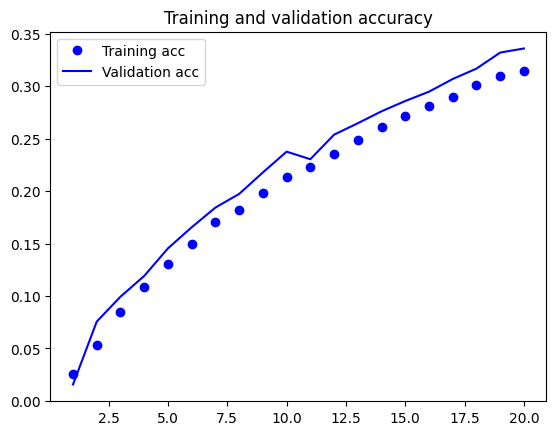

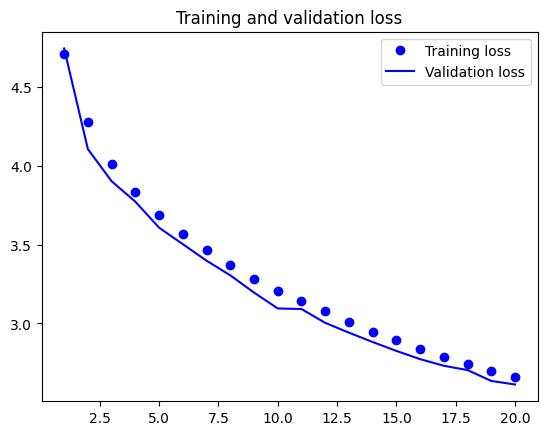

313/313 [==============================] - 1s 3ms/step
10000
                   precision    recall  f1-score   support

           beaver    0.65169   0.58000   0.61376       100
          dolphin    0.37313   0.50000   0.42735       100
            otter    0.26667   0.20000   0.22857       100
             seal    0.22222   0.10000   0.13793       100
            whale    0.09934   0.15000   0.11952       100
         aquarium    0.21656   0.34000   0.26459       100
             fish    0.31461   0.28000   0.29630       100
              ray    0.32258   0.40000   0.35714       100
            shark    0.40000   0.40000   0.40000       100
            trout    0.58065   0.36000   0.44444       100
          orchids    0.30435   0.14000   0.19178       100
          poppies    0.34615   0.09000   0.14286       100
            roses    0.31731   0.33000   0.32353       100
       sunflowers    0.39394   0.26000   0.31325       100
           tulips    0.31429   0.11000   0.16296     

In [ ]:
import math
import time

def EfficientNet(width_coefficient=1.0, depth_coefficient=1.0, resolution_coefficient=1.0, dropout_rate=0.2):
    model = models.Sequential()

    def round_filters(filters, multiplier):
        divisor = 8
        min_depth = None
        if not multiplier:
            return filters

        filters *= multiplier
        min_depth = divisor
        new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
        if new_filters < 0.9 * filters:
            new_filters += divisor
        return int(new_filters)

    def round_repeats(repeats, multiplier):
        if not multiplier:
            return repeats
        return int(math.ceil(multiplier * repeats))

    def MBConvBlock(model, input_filters, output_filters, kernel_size, strides, expand_ratio, se_ratio, id_skip, drop_connect_rate):
        expand_filters = input_filters * expand_ratio
        model.add(layers.Conv2D(expand_filters, kernel_size=1, padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())

        model.add(layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())

        if 0 < se_ratio <= 1:
            filters_se = max(1, int(input_filters * se_ratio))
            se = layers.GlobalAveragePooling2D()(model.layers[-1].output)
            se = layers.Reshape((1, 1, expand_filters))(se)
            se = layers.Conv2D(filters_se, kernel_size=1, activation='relu', padding='same')(se)
            se = layers.Conv2D(expand_filters, kernel_size=1, activation='sigmoid', padding='same')(se)
            x = layers.multiply([model.layers[-1].output, se])
        else:
            x = model.layers[-1].output

        model.add(layers.Conv2D(output_filters, kernel_size=1, padding='same', use_bias=False))
        model.add(layers.BatchNormalization())

        if id_skip and strides == 1 and input_filters == output_filters:
            if drop_connect_rate:
                model.add(layers.Dropout(drop_connect_rate))
            model.add(layers.add([model.layers[-1].output, model.layers[-7].output]))

        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Conv2D(round_filters(32, width_coefficient), kernel_size=3, strides=(2, 2), padding='same', use_bias=False, input_shape=(32,32,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    num_blocks = 5
    strides = [1, 2, 2, 2, 2, 1]
    kernels = [3, 3, 3, 3, 5, 5]
    filters = [16, 24, 40, 80, 112, 112]
    depth = round_repeats(1, depth_coefficient)
    drop_rate = dropout_rate / num_blocks

    for i in range(num_blocks):
        MBConvBlock(model,
                    input_filters=round_filters(filters[i], width_coefficient),
                    output_filters=round_filters(filters[i + 1], width_coefficient),
                    kernel_size=kernels[i],
                    strides=strides[i],
                    expand_ratio=6,
                    se_ratio=0.25,
                    id_skip=True,
                    drop_connect_rate=drop_rate)

    model.add(layers.Conv2D(round_filters(1280, width_coefficient), kernel_size=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(100, activation='softmax'))

    return model

EfficientNet = EfficientNet()

optimizer = Adam(learning_rate=0.0001)
EfficientNet.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

EfficientNet.summary()

def gpu():
    with tf.device('/device:GPU:0'):


        training_start = time.time()
        history = EfficientNet.fit(X_train, y_train, epochs=20, batch_size=64,
                                  validation_data=(X_validation, y_validation))
        training_stop = time.time()
        training_time = training_stop - training_start
        print(f"Training time: {training_time}")
        training_plot(history)
        evaluation(EfficientNet)
        scores = EfficientNet.evaluate(test_images, test_labels)
        print(f'accuracy on test set: {EfficientNet.metrics_names[1]} of {scores[1]*100}')
        return EfficientNet

EfficientNet = gpu()

test_loss, test_acc = EfficientNet.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')